# Exercise 5

# Part A
In the first part of exercise 5, we will investigate the dynamics of a disordered protein using the string-of-beads model. In the second part, we will review the course material briefly using multiple-choice questions.
## Preparations
### I. Installing IMP
The Integrative Modeling Platform [IMP](https://integrativemodeling.org/) is a software package for integrative (data-driven) modeling of molecular structure and dynamics. It is written in C++ and Python, and has a Pythn interface. To allow Google Colab to use IMP, we shall first install the IMP package:

In [ ]:
!echo "deb https://integrativemodeling.org/latest/download $(lsb_release -cs)/" > /etc/apt/sources.list.d/salilab.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 22A3BF2B
!apt update
!apt install imp
import sys
sys.path.append('/usr/lib/python3.6/dist-packages')

Executing: /tmp/apt-key-gpghome.AlAmiMEEP2/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 22A3BF2B
gpg: key EE70051722A3BF2B: "Ben Webb <ben@salilab.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 https://integrativemodeling.org/latest/download bionic/ InRelease
Hit:10 http://archiv

Import some IMP packages:

In [ ]:
import IMP.atom
import IMP.algebra
import IMP.rmf
import IMP.core
import RMF
import IMP.container
import IMP.display
import IMP.npctransport

### II. Classes 
We prepared two classed, one for representing protein chains as strings-of-beads, and the other for generating such classes (a "factory" class)

#### ProteinChain class
We defined a class called `ProteinChain` for you. This class holds information about a single protein chain, represented as a string of beads. It's a simple class - some key methods include `beads()` - returning the bead of the string, and `restraint()` - returning the springs connecting the beads (you will see). 

We've kept it hidden (though you can feel free to look inside). Don't worry if you don't understand all of the code - just run this cell for now:

In [ ]:
#@title
from dataclasses import dataclass

@dataclass # https://docs.python.org/3/library/dataclasses.html
class ProteinChain:
  '''
  A string-of-beads representation of a protein chain
  from specified beads. The beads are connected by a restraint
  (think springs between consecutive beads)
  '''
  # the "parent" of all beads in the chain
  root_p : IMP.Particle 
   # the list of bead particles comprising the chain
  beads : list 
  # a spring restraint on consecutive beads
  restraint : IMP.Restraint 
  # The protein sequence that this chain represents
  sequence : str 

  def __post_init__(self): # this is called by automatically generated __init__
      # make sure root is the parent of all beads
      for bead in self.beads:
        assert IMP.atom.Hierarchy(bead).get_parent() == self.root_as_h

  @property
  def model(self) -> IMP.Model : 
    return self.root_p.get_model()
    
  @property # Hierarchy is a decorator 
  def root_as_h(self) -> IMP.atom.Hierarchy : 
    return IMP.atom.Hierarchy(self.root_p)

#### ProteinChainFactory class
We also included a class for generating `ProteinChain` objects for various protein sequences. Details will be explained below, just run for now:

In [ ]:
#@title
FAKE_MASS = 1.0

class ProteinChainFactory:
    '''
    A class for generating chains of beads
    '''
    def __init__(self,
                 model : IMP.Model, 
                 default_radius_A : float = 10.0 , # bead radius in angstroms (10^-10 m)
                 relative_rest_distance : float = 2.0, # distance between bead centers, relative to radius
                 k_kcal_per_mol_per_A2 : float = 1.0, # force coefficient for spring connecting consecutive beads in kcal/mol/A^2 (force is k*distance
                 nres_per_bead : int = 5):
        '''
        :param model 
        :param default_radius_A       Bead radius in angstroms
        :param relative_rest_distance Distance between bead centers, relative to radius
        :param k_kcal_per_mol_per_A2  Force coefficient for spring connecting consecutive beads 
                                      in kcal/mol/A^2 units
        :param nres_per_bead          Number of protein residues represented by a single bead
        '''
        self._model = model
        self._default_radius_A = default_radius_A
        self._rest_distance_A = relative_rest_distance * default_radius_A 
        self._k_kcal_per_mol_per_A2 = k_kcal_per_mol_per_A2
        self._nres_per_bead = nres_per_bead
    @property
    def model(self): return self._model
    @property
    def default_radius_A(self): return self._default_radius_A
    @property
    def rest_distance_A(self): return self._rest_distance_A
    @property
    def k_kcal_per_mol_per_A2(self): return self._k_kcal_per_mol_per_A2
    @property
    def nres_per_bead(self): return self._nres_per_bead
    
    def _create_bead(self, 
                     name : str):
        p= IMP.Particle(self.model, name)
        p_as_xyzr= IMP.core.XYZR.setup_particle(p) # A Decorator design pattern - adding functionality to an object at run time (~run-time inheritance)
        p_as_xyzr.set_coordinates_are_optimized(True)
        p_as_xyzr.set_radius(self.default_radius_A)
        IMP.atom.Mass.setup_particle(p, FAKE_MASS)   # required by Hierarchy
        IMP.atom.Diffusion.setup_particle(p)
        IMP.atom.Hierarchy.setup_particle(p) # allow inclusion in IMP hierarchies
        IMP.display.Colored.setup_particle(p,
                                           IMP.display.get_display_color(0))
        return p

    def _create_restraint(self,
                          beads #spring constant
                       ):
      hdps = IMP.core.HarmonicDistancePairScore(self.rest_distance_A, 
                                                self.k_kcal_per_mol_per_A2)
      cpc = IMP.container.ConsecutivePairContainer(self.model, beads) # convention - use abbreviation for multiword class names
      pr = IMP.container.PairsRestraint(hdps, cpc)
      return pr, hdps


    def create(self, 
               sequence : str, # protein sequence 
               name: str): # a name of your choice for the protein chain
      p= IMP.Particle(self.model, name)
      p_as_h = IMP.atom.Hierarchy.setup_particle(p) # allow inclusion in IMP hierarchies
      # add beads:
      n = len(sequence)
      nbeads = max(1, round(n / self.nres_per_bead))
      beads = []
      for i in range(nbeads):
        bead = self._create_bead(f"{name}_{i}") 
        p_as_h.add_child(bead) 
        beads.append(bead)
      # restrain beads on a "string":
      restraint, harmonic_distance_pair_score = self._create_restraint(beads)
      return ProteinChain(root_p = p, 
                          beads = beads, 
                          restraint = restraint,
                          sequence = sequence)

## Building a dynamic model - parts, interactions, dynamics
OK, let's begin by building our first dynamic model! As we learned in class, a dynamic model stands on three pillars: parts, interactions, and dynamics. 

But first we need to construct an [IMP `model`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1Model.html):

In [ ]:
m = IMP.Model()

### I. Add parts 
#### Generate strings of beads
In IMP, model parts are called [Particles](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1Particle.html). The beads in our `ProteinChain` object are such particles - in this case, they represent physical objects with Cartesian coordinates. 

To generate two string of beads, we use the `ProteinChainFactory` class `create()` method:  

In [ ]:
protein_chain_factory = ProteinChainFactory \
  (model = m, # the model in which the beads reside
   default_radius_A = 10.0, # radius of a bead
   k_kcal_per_mol_per_A2 = 5.0, # the force coefficient for the spring holding consecutive beads together (large number = stiff spring)
   relative_rest_distance = 3.0, # the resting distance between bead centers, relative to the radius of single bead
   nres_per_bead = 20) # number of residues per bead in the string-of-beads
seq = "MSDQSQEPTMEEILASIRRIISEDDAPAEPAAEAAPPPPPEPEPEPVSFDDEVLELTDPI" \
      "APEPELPPLETVGDIDVYSPPEPESEPAYTPPPAAPVFDRDEVAEQLVGVSAASAAASAF" \
      "GSLSSALLMPKDGRTLEDVVRELLRPLLKEWLDQNLPRIVETKVEEEVQRISRGRGA"
label = "popZ"
nchains = 2
chains = []
for i in range(nchains):
  chain = protein_chain_factory.create(seq, f"{label}_{i}")
  chains.append(chain)

### Keep chains in a hierarchical data structure

Next, we create a hierarchical data struture, in which the two chain descend from a common root particle called `p_root`. Note that ProteinChainFactory made sure that the beads of each chain also descend from a common root `protein_chain.root_as_h`.




In [ ]:
p_root= IMP.Particle(m, "root")
h_root = IMP.atom.Hierarchy.setup_particle(p_root) # decorator
for chain in chains:
  h_root.add_child(chain.root_as_h)

**Explanation**: IMP Particles don't have to represent actual physical particles. To allow *particle* `p_root` to have children, we [decorate](https://https://en.wikipedia.org/wiki/Decorator_pattern) it using the [`IMP.atom.Hierarchy` class](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1atom_1_1Hierarchy.html). The [decorator design pattern](https://https://en.wikipedia.org/wiki/Decorator_pattern) adds new functions to existing classes at runtime instead of during compile time. Think about `h_root` as particle `p_root` cast as class Hierarchy.

### II. Add interactions
Interactions in IMP are created using the concept of a "restraint" acting on a group of particles (a single particle, a pair of particles, etc.). All restraints derive from the class [`Restraint`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1Restraint.html). 
 
We first define an [`ExcludedVolumeRestraint`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1core_1_1ExcludedVolumeRestraint.html) object - telling IMP that different beads should not overlap with each other, at least not too much:

In [ ]:
def get_all_beads(chains):
  beads_set = set().union(*[chain.beads for chain in chains])
  return list(beads_set)

# Add excluded volume restraints among all (close pairs of) particles:
evr = IMP.core.ExcludedVolumeRestraint(get_all_beads(chains), # particles to be restraints
                                      1.0, # force constant
                                      10.0, # slack parameter affecting speed only
                                      "Excluded-Volume" # a string identifier
                                       ) 

The springs between the beads of each protein chain were already defined by ProteinChainFactory, so now we create `rsf`, a scoring function (a.k.a. energy function) made of our restraints.

In [ ]:
restraints = [chain.restraint for chain in chains] + [evr]
rsf = IMP.core.RestraintsScoringFunction(restraints, 
                                         "Scoring function") # Energy function

### III. Add dynamics
Finally, we create a [`BrownianDynamics`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1atom_1_1BrownianDynamics.html) object, which enables us to simulate our interacting parts:

In [ ]:
# BD
bd = IMP.atom.BrownianDynamics(m)
bd.set_scoring_function(rsf) # tell BD about our scoring (energy) function
bd_step_size_fs = 1000.0 # simulation time step in femotoseconds (10^-15 sec)
bd.set_maximum_time_step(bd_step_size_fs) 
T = 600 # temperature in Kalvin
bd.set_temperature(T)

#### Making a movie (trajectory) file
We conclude by telling our simulation to output a trajectory (movie) file every 10000 frames. The movie is saved using the [Rich Molecular File format](https://integrativemodeling.org/rmf/format.html), which can be viewed using e.g. the [Chimera software](https://www.cgl.ucsf.edu/chimera/download.html) or [ChimeraX](https://cxtoolshed.rbvi.ucsf.edu/apps/chimeraxrmf).
 
**Note:** if you get a "UsageError: "Opening a file that is still being written is asking for trouble." error for any reson, just change the filename variable

In [ ]:
rmf_filename = "myTrajectoryFilm4.rmf"
rmf = RMF.create_rmf_file(rmf_filename)
rmf.set_description("Brownian dynamics trajectory with {}fs timestep.\n"\
                    .format(bd_step_size_fs))
IMP.rmf.add_hierarchy(rmf, h_root) # Telling the movie that it should save all descendents of h_root
IMP.rmf.add_restraints(rmf, restraints) # the restraints are also saved and can be viewed in Chimera
sos = IMP.rmf.SaveOptimizerState(m, rmf) # an optimizer state is invoked every n frames of simulation by the BD simulation
sos.set_simulator(bd)
frames_interval = 10000
sos.set_period(frames_interval) 
bd.add_optimizer_state(sos)
sos.update_always("initial conformation") # save the initial conformation to the RMF file


## Simulating dynamics
Without further ado, let's simulate our system using `bd.optimize(n)` where `n` is the number of time steps to simulate. 

We shall keep a few statistics every `n_inner_cycle` frames - the simulation time, the energy of the system (our scoring function), and the distance between the first and last bead of each chain.


In [ ]:
T_ns = [] # time in nanoseconds
E = [] # energy
D = [ [] for chain in chains ]
n_outer = 50000 # outer loop number of iterations
n_inner = 250 # optimization per iteration
for i in range(n_outer):
  time_fs = bd.get_current_time()
  time_ns = time_fs * 1e-6 # a nanosecond is a million femtoseconds
  if (i % (n_outer//10) == 0):
    print(f"Simulated for {time_ns:.1f} nanoseconds so far")
  bd.optimize(n_inner)
  T_ns.append(time_ns) # keep time
  E.append(bd.get_last_score()) # keep energy
  for i, chain in enumerate(chains): # keep distances for each chain
    distance = IMP.core.get_distance(IMP.core.XYZ(chain.beads[0]), 
                                     IMP.core.XYZ(chain.beads[-1]))
    D[i].append(distance)
print(f"FINISHED. Simulated for {time_ns:.1f} nanoseconds in total.")
rmf.flush() # make sure RMF file is properly saved

Simulated for 0.0 nanoseconds so far
Simulated for 1250.0 nanoseconds so far
Simulated for 2500.0 nanoseconds so far
Simulated for 3750.0 nanoseconds so far
Simulated for 5000.0 nanoseconds so far
Simulated for 6250.0 nanoseconds so far
Simulated for 7500.0 nanoseconds so far
Simulated for 8750.0 nanoseconds so far
Simulated for 10000.0 nanoseconds so far
Simulated for 11250.0 nanoseconds so far
FINISHED. Simulated for 12499.8 nanoseconds in total.


Let's convert to numpy array - it will be easier to manipulate that way:

In [ ]:
import numpy as np
T_ns = np.array(T_ns) # this will be convenient later
E = np.array(E) # likewise
D = np.array(D)

**Explanations:**

To compute the energy of the system we use the `bd.get_last_score()` method.

To compute the distance between the centers of two bead particles, we use the [`IMP.core.get_distance()`](https://integrativemodeling.org/2.15.0/doc/ref/namespaceIMP_1_1core.html#af2049fdca8aae38e86549cfdeff1d1fc) function. This functions acts on [`IMP.core.XYZ`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1core_1_1XYZ.html) objects. 

*Advanced note:* bead particles can be converted (cast) to `IMP.core.XYZ` objects because they were decorated as such by our `ProteinChainFactory` class.

## Visualizing simulation results
Let's see what happened. Since we kept statistics, we can now plot the energy and the distance between beads as a function of time. Optionally, you can frist inspect the resulting simulation as a movie in Chimera.

####**Bonus Question A0 (+2):**
Download and install the [Chimera software](https://www.cgl.ucsf.edu/chimera/download.html), download the output RMF file (press on the files icon in the left tab and look for the output file, you can download it from there). Open it in Chimera and play the movie. Explore the hierarchy of particles on the right panel. You may select differtent chains or beads, color them in different colors, etc. 

**Please share your observations in a few sentences (in Hebrew if you like).**

*Note:* Alternatively, you can use ChimeraX. It requires installation of the RMF plugin (Tools - more tools - RMF - Install), and a few simple command lines - if you're interested, you can try the following sequence of commands and take it from there:
1.   `open "<PATH>/<filename>.rmf"`
2.   `rmf readtraj #1.1` (you may need to replace 1.1 with the appropraiate ID on the Models panel)
3.   `coordset slider #1.1` (this will open a slider for playing the movie, you may need to replace 1.1 with the appropriate ID as before)
  

####**Bonus Answer A0:**
<תשובה>

####**Question A1:**
Please add appropriate code, such that the simulation energy is plotted as a function of time using [`matplotlib.pyplot.plot()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) function. 

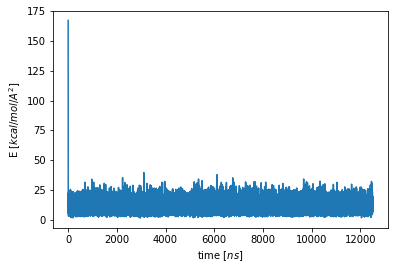

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(T_ns,E)
plt.xlabel(r'time [$ns$]')
plt.ylabel(r'E [$kcal/mol/A^2$]')
plt.show()


####**Question A2:**
**You may answer in hebrew (here and in all questions below).** 

What happened to the simulation energy at the early stages of the simulations? Why?

####**Answer A2:**
בשלבים ראשונים של הסימולציה קיבלנו כי הערך האנרגטי שלה מאוד גבוה.
בהתחלה כל החלקיקים צמודים אל השורש, על כן אחד האילוצים שבודקים את המרחק בין מרכזי הרדיוסים מקבל ערכים גבוהיים עבור כל הנקודות(כל המרכזים קרובים מאוד).

###**Question A3:**
 
Let's plot the simulation energy only after the initial equilibration time. Change the value of `T_ns_threshold` until the plot only shows a simulation energy that does not trend down

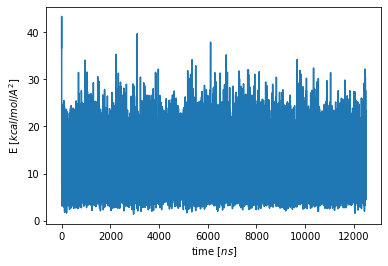

In [ ]:
#A3
import numpy as np
T_ns_threshold = 1.2395 # CHANGE THIS LINE ONLY
no_start = (T_ns > T_ns_threshold)
plt.plot(T_ns[no_start], E[no_start], '-') 
plt.xlabel(r'time [$ns$]')
plt.ylabel(r'E [$kcal/mol/A^2$]')
plt.show()

####**Question A4:** 
**You may answer in Hebrew here and in all questions below.** 

Print the mean and standard deviation of the simulation energy by running the next cell of code. What would happen to the standard deviation of the energy if we decreased the simulation temperature? Would it go up or down? Please explain why so based on the equation of Brownian dynamics that we learned in class. 

**Note -** it appeared in the last lecture on dynamics, for example, on slides 8-9. 

Optionally, feel free to create a copy of this document and test what happens when you actually change the simulation temperature by changing the code above `bd.set_temperature(T)`.

####**Answer A4:**
<תשובה>

In [ ]:
print(f"The mean energy is {np.mean(E[no_start]):.2f}")
print(f"The std-deviation of the energy is {np.std(E[no_start]):.2f}")

The mean energy is 10.80
The std-deviation of the energy is 4.14


###**Question A5:**
Inspect the equation of BD as in the previous question. 

*Fact:* The diffusion coefficent *D* in the equation increases proportionally to the temperature *T*. In other words, you may substitute *D* for *cT*. 

If *T* tends (שואף) to zero, what would be the form of the BD equation? Is there any term that disappears?

*Hint:* you don't have to, but if you change the `bd.set_temperature()` line above, you can check it first hand. Don't forget to change it back again (or work on a copy of this notebook).

###**Answer A5:**
<תשובה>


###**Question A6:**
When *T* tends to zero, what algorithm do we get? 

*Hint:* we learned it early on in the course (circa lectures 4, 5, on optimization).

###**Answer A6:**
<תשובה>

###**Question A7:**
The following code plots the end-to-end distance of the protein chains. The chains movement is somewhat remeniscent of changes in the stock market. How come? What universal phenomenon that we learned in class may explain this qualitative similarity?
 
###**Answer A7:**
<תשובה>

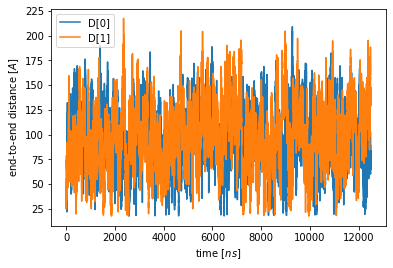

In [ ]:
from matplotlib import cm
colors =  cm.get_cmap("tab10")
for i,Di in enumerate(D):
  plt.plot(T_ns[no_start], Di[no_start],
           color=colors(i % 10), label=f'D[{i}]') 
plt.xlabel(r'time [$ns$]')
plt.ylabel(r'end-to-end distance [$A$]')
plt.legend()
plt.show()

###**Bonus question A8 (+2):**
(Bonus +2 points) Let us plot the distribution of the system's energy over time (in units of kcal/mol/A^2 - nevermind) by running the following cell. We know that Brownian dynamics simulations converge to the Boltzmann distribution, that is, their probability to be in a certain configuration decreases exponentially as the energy of that configuration increases. 

How come the following histogram does not decay exponentially with increasing energy? 

*Hint*: Is there an equal number of configurations for each energy level?

###**Bonus answer A8 (+2):**
<תשובה>


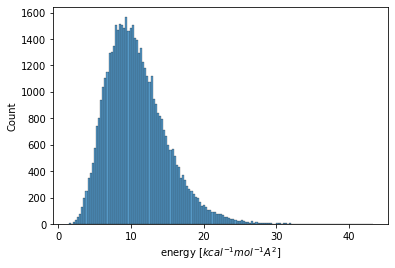

In [ ]:
import seaborn as sns
ax = sns.histplot(E[no_start])
ax.set_xlabel(r'energy [$kcal^{-1}mol^{-1}A^2$]')
plt.show()


###**Question A9:**

Let's plot the distribution of end-to-end-distances over time in the two chains combined. 

  a. According to what we learned in class, why is it (approximately) a Gaussian?

  b. Why is it not precisely a Gaussian? 
  
  *Hint for b:* Are the springs the only interactions between beads? Or did we add another type of interaction except the springs? 

###**Answer A9:**


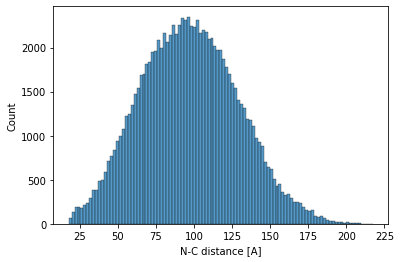

In [ ]:
ax = sns.histplot(np.concatenate(D[0:]))
ax.set_xlabel(r'N''-C'' distance [A]')
plt.show()

####**Enrichment:**
Let's inspect the code of classes `ProteinChain` and `ProteinChainFactory` way above by pressing "show code". This brief explanation is provided for context, you can move on with the exercise if you like.

The method `create_bead()` creates a single bead, and decorates it with  [`IMP.core.XYZR`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1core_1_1XYZR.html), [`IMP.atom.Mass`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1atom_1_1Mass.html), [`IMP.atom.Diffusion`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1atom_1_1Diffusion.html), and [`IMP.display.Colored`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1display_1_1Colored.html).
    
    def _create_bead(self, 
                     name : str):
        p= IMP.Particle(self.model, name)
        p_as_xyzr= IMP.core.XYZR.setup_particle(p) # A Decorator design pattern - adding functionality to an object at run time (~run-time inheritance)
        p_as_xyzr.set_coordinates_are_optimized(True)
        p_as_xyzr.set_radius(self.default_radius_A)
        IMP.atom.Mass.setup_particle(p, FAKE_MASS)   # required by Hierarchy
        IMP.atom.Diffusion.setup_particle(p)
        IMP.atom.Hierarchy.setup_particle(p) # allow inclusion in IMP hierarchies
        IMP.display.Colored.setup_particle(p,
                                           IMP.display.get_display_color(0))
        return p


The method `_create_restraint` adds a spring to the simulation between each pair of consecutive beads. It first creates a function that increases quadratically from a certain rest distance - using the class [`IMP.core.HarmonicDistancePairScore`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1core_1_1HarmonicDistancePairScore.html). The [`IMP.container.PairsRestraint`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1container_1_1PairsRestraint.html) object `pr` is a restraints that applies this function (`hdps`) over each pair of consecutive beads (`cpc`).

    def _create_restraint(self,
                          beads #spring constant
                       ):
      hdps = IMP.core.HarmonicDistancePairScore(self.rest_distance_A, 
                                                self.k_kcal_per_mol_per_A2)
      cpc = IMP.container.ConsecutivePairContainer(self.model, beads) # convention - use abbreviation for multiword class names
      pr = IMP.container.PairsRestraint(hdps, cpc)
      return pr, hdps




# Probabilistic modeling (enrichment)

There are no questions to answer in this section, so you can skip right on to **Part II** if you like. If you're still here, you will find some simple code for fitting the probability distribution of the energy and chain end-to-end distance distributions above, using the probabilistic modeling package [PyMC3](https://docs.pymc.io/).

First install some required packages:

In [ ]:
!pip install theano-pymc
!pip install pymc3==3.11.1

Define a probabilistic model made of a bunch of random variables ("RVs"):

In [ ]:
import pymc3 as pm
import numpy as np
pm_model = pm.Model()
with pm_model:
  rv_E_mu = pm.Normal('E_mu', mu = 20, sigma = 20)
  rv_E_sigma = pm.Normal('E_sigma', mu = 20, sigma = 20)
  rv_E = pm.Normal('E', mu = rv_E_mu, sigma = rv_E_sigma, 
                   observed = E)
  rv_D_mu = pm.Normal('D_mu', mu = 100, sigma = 50)
  rv_D_sigma = pm.Normal('D_sigma', mu = 50, sigma = 25)
  rv_D = pm.Normal('D', mu = rv_D_mu, sigma = rv_D_sigma, 
                   observed = np.concatenate(D))
gv = pm.model_to_graphviz(pm_model)        

Plot probabilistic relations:

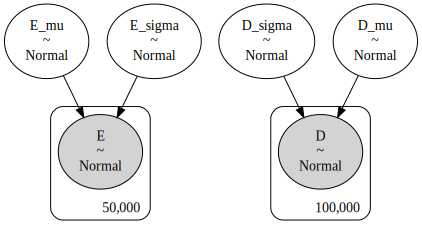

In [ ]:
gv

Run Hamiltonian Markov-Chain Monte-Carlo to sample the mean (mu) and std-dev (sigma) for the various distributions:

In [ ]:
with pm_model:
    trace = pm.sample(500, chains=2);

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [D_sigma, D_mu, E_sigma, E_mu]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 69 seconds.


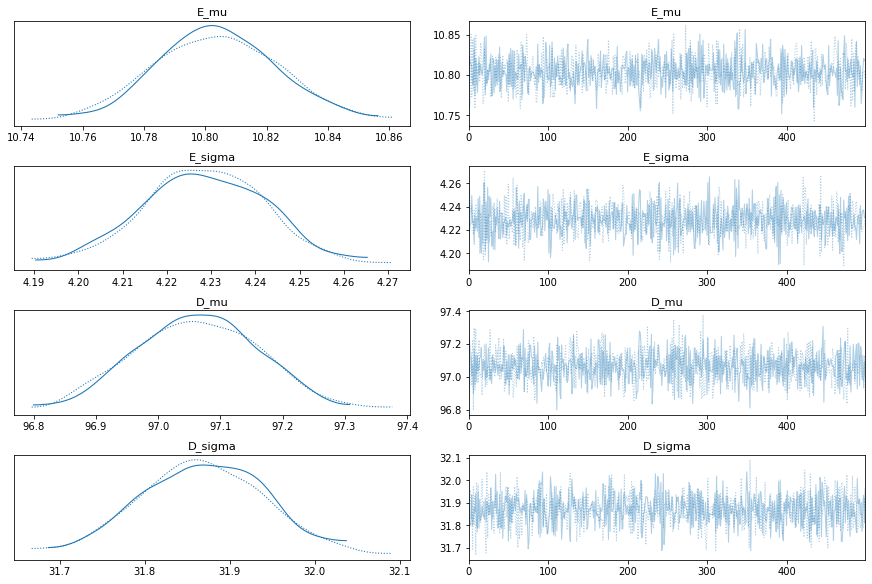

In [ ]:
#!pip install arviz
import arviz as az
with pm_model:
    az.plot_trace(trace)

In [ ]:
az.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
E_mu,10.804,0.019,10.771,10.843,0.000,0.000,1898.0,824.0,1.0
E_sigma,4.228,0.014,4.199,4.251,0.000,0.000,1536.0,666.0,1.0
D_mu,97.063,0.098,96.882,97.238,0.002,0.002,1858.0,846.0,1.0
D_sigma,31.868,0.071,31.736,31.999,0.002,0.001,1573.0,811.0,1.0


# Part II - Course overview
**אפשר לענות בעברית**



1. List two different ways to represent a protein structure discussed in the course.

2. Explain briefly, in your own words, the steps of MCMC algorithm learned in class for sampling protein conformations using the Metropolis-Hastings criterion.

3. For each of the following neural networks layers, explain what it does and what we use it for?

  a. 1D convolutional layer

  b. Dropout layer

  c. Activation layer (Relu, Sigmoid…)

4. In Gradient Descent algorithms and Neural networks:

  a. what does the ‘step size’ parameter stand for? (also called learning rate). 

  b. What happens when it is too small?  

  c. What happens when it is too large?

5. Write down the input and the output of the following methods of structural bioinformatics, as described in the course (1-2 short sentences each):

  a. Proteins structural alignment

  b. ab initio folding 

  c. Comparative modeling

  d. K-means clustering

  e. Protein-protein docking 

  f. Molecular dynamics 

  g. Motion planning 

  h. Protein folding using deep learning (RaptorX/trRosetta/AlphaFold)
